In [119]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product 
from statsmodels.tsa.stattools import adfuller
import random
import warnings
warnings.simplefilter(action='ignore', category=Warning)

# DATA INPUT

In [70]:
df = pd.read_parquet("data_source/all_data_revenue.parquet", engine="fastparquet")
list_5000_merchant = pd.read_csv("5000merchant.csv", index_col=0)
industry = pd.read_csv("data_source/vega_industry.csv")


In [1]:
check = df[df['merchant_id'] == "00ee521e33e32956b48f933d18f9350c51d03034a8d38e3da4f833100572e891"]
check

NameError: name 'df' is not defined

# MODEL FUNCTION

## Seperate dataset

In [237]:
def seperating_dataset(data):
    # counting data point of each merchant
    data_point = data.groupby('merchant_id')['based_month'].count()
    # seperating list of merchant
    less_than_13m = data_point[(data_point >= 4) & (data_point <= 13)].index
    more_than_13m = data_point[data_point > 13].index

    df_ma = data[data['merchant_id'].isin(less_than_13m)]
    df_hw = data[data['merchant_id'].isin(more_than_13m)]
    return df_ma, df_hw

## Holt-winter model

### Preprocessing

In [148]:
def detecting_outlier(df):
    Q1 = df['net_revenue'].quantile(0.25)
    Q3 = df['net_revenue'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # df.loc[df['net_revenue'] < lower_bound, 'net_revenue'] = lower_bound
    df.loc[df['net_revenue'] > upper_bound, 'net_revenue'] = upper_bound

    return df

def detecting_missing_value(df): 
    df = df.reset_index(drop=True)
    for i in range(len(df)):
        if i == 0:
            continue
        mean_previous_month = df.loc[:i-1,'net_revenue'].mean()
        if (df.loc[i,'net_revenue'] == 0) or (df.loc[i,'net_revenue'] < 0):
            df.loc[i,'net_revenue'] = mean_previous_month
    return df

def indexing_date(df):
    df = df.set_index('based_month')
    return df

### Training step

In [80]:
# Viết function tìm ra best param 
def finding_best_param(data, param_grid, predicted_month: int):
    optimal_params = {} 
    best_mse = np.inf 
    best_param = None
    for param in param_grid:
        seasonal_param, trend_param, seasonal_period = param
        train_data, test_data = data[:-predicted_month], data[-predicted_month:]
        try:
            model = ExponentialSmoothing(train_data['net_revenue'], seasonal= seasonal_param, trend= trend_param, seasonal_periods=seasonal_period)
            result = model.fit() 
            forecast = result.forecast(steps=len(test_data))
            mse = mean_squared_error(test_data['net_revenue'], forecast)
        except Exception as error:
            continue
        if mse < best_mse:
            best_mse = mse 
            best_param = param
    optimal_params = best_param
    return optimal_params

In [142]:
def training_model(data_train, predicted_month: int):
    customer_best_param = {}
    seasonal_param = ['add','mul']
    trend_param = ['add','mul']
    seasonal_period = list(range(2,13))

    param_grid = list(product(seasonal_param, trend_param, seasonal_period))
    for index, (retailer_id, retailer_data) in enumerate(data_train.groupby('merchant_id')):
        try:
            best_param = finding_best_param(retailer_data, param_grid, predicted_month)
            customer_best_param[retailer_id] = best_param
            print(f'Finish finding the best param for retailer_id {retailer_id}, index = {index + 1}')
        except ValueError as error:
            print("ValueError occurred for retailer_id {}: {}".format(retailer_id, error))
            continue
    return customer_best_param

### Forecast step

In [139]:
def hold_winter_model(data_train, predicted_month: int, retailer_id, optimal_param):
    # Filter dataset
    data_train = data_train[data_train['merchant_id'] == retailer_id]

    combine_results = pd.DataFrame()
    # Apply model
    try:
        seasonal_param, trend_param, seasonal_period = optimal_param
        model = ExponentialSmoothing(data_train['net_revenue'], seasonal=seasonal_param, trend=trend_param, seasonal_periods=seasonal_period)
        results = model.fit()
        forecast = results.forecast(steps=predicted_month)
        # Saving result as dataframe
        results_df = pd.DataFrame(forecast.items()) 
        results_df['merchant_id'] = retailer_id
        results_df = results_df.rename(columns={0 : 'based_month', 1: 'net_revenue'})
        results_df = pd.concat([data_train[-3:].reset_index(), results_df], ignore_index=True)
        # Hiệu chỉnh các tháng có output quá lớn & hoặc bị âm
        for i in range(0, len(results_df)):
            mean_previous_months = results_df.loc[:i-1, 'net_revenue'].mean()
            std_previous_months = results_df.loc[:i-1, 'net_revenue'].std()
            threshold = mean_previous_months + 3 * std_previous_months # rule of very high : >= 3 standard deviations
            if (results_df.loc[i, 'net_revenue'] > threshold):  # threshold for 'very high' or 'negative' value
                results_df.loc[i, 'net_revenue'] = mean_previous_months 
            elif results_df.loc[i, 'net_revenue'] < 0:
                results_df.loc[i, 'net_revenue'] = 0
    except Exception as error:
        # Thay param seasonal và trend mặc định = "add"
        model = ExponentialSmoothing(data_train['net_revenue'], seasonal=seasonal_param, trend=trend_param, seasonal_periods=seasonal_period)
        results = model.fit()
        forecast = results.forecast(steps=predicted_month)
        # Saving result as dataframe
        results_df = pd.DataFrame(forecast.items()) 
        results_df['merchant_id'] = retailer_id
        results_df = results_df.rename(columns={0 : 'based_month', 1: 'net_revenue'})
        results_df = pd.concat([data_train[-3:].reset_index(), results_df], ignore_index=True)
        # Hiệu chỉnh các tháng có output quá lớn & hoặc bị âm
        for i in range(0, len(results_df)):
            mean_previous_months = results_df.loc[:i-1, 'net_revenue'].mean()
            std_previous_months = results_df.loc[:i-1, 'net_revenue'].std()
            threshold = mean_previous_months + 3 * std_previous_months # rule of very high : >= 3 standard deviations
            if (results_df.loc[i, 'net_revenue'] > threshold):  # threshold for 'very high' or 'negative' value
                results_df.loc[i, 'net_revenue'] = mean_previous_months 
            elif results_df.loc[i, 'net_revenue'] < 0:
                results_df.loc[i, 'net_revenue'] = 0               
    # Combine output thành bảng cuối cùng
    combine_results = pd.concat([combine_results, results_df], ignore_index=False)
    # Loại bỏ và chỉ giữ các cột dự đoán
    combine_results = combine_results.loc[~combine_results.index.isin([0,1,2])]
    return combine_results


In [155]:
def forecasting_revenue_hw(data_train, customer_best_param, predicted_month: int):
    forecast_ret = pd.DataFrame()
    for index, (retailer_id, optimal_param) in enumerate(customer_best_param.items()):
        result = hold_winter_model(data_train, predicted_month , retailer_id, optimal_param)
        forecast_ret = pd.concat([forecast_ret, result], ignore_index=True)
        print(f"Finish retailer_id {retailer_id}, index = {index + 1}")
    return forecast_ret

## Average revenue method

In [172]:
def average_revenue(data, merchant_id, predicted_month: int):
    # Preprocessing
    data = data.groupby('merchant_id', group_keys=False).apply(detecting_outlier)
    data = data.groupby('merchant_id', group_keys=False).apply(detecting_missing_value)
    # 
    for i in range(1, predicted_month + 1):
        # Calculate the average of all previous revenues for the merchant
        mean_revenue = data['net_revenue'].mean()
        # Create a new date for the predicted month
        last_month = data['based_month'].max()
        next_month = last_month + pd.DateOffset(months=1)

        # Append new row with predicted revenue
        new_row = {'based_month': next_month, 'merchant_id': merchant_id, 'net_revenue': mean_revenue}
        data = pd.concat([data, pd.DataFrame([new_row])], ignore_index=True)

    for i in range(len(data)):
        if data.loc[i, 'net_revenue'] < 0:
            data.loc[i, 'net_revenue'] = 0
    data = data[-predicted_month:]
    return data

def forecasting_revenue_ma(data_train, predicted_month: int):
    avg_rev_df = pd.DataFrame()
    for index, (retailer_id, retailer_data) in enumerate(data_train.groupby('merchant_id')):
        try:
            result = average_revenue(retailer_data, retailer_id, predicted_month)
            avg_rev_df = pd.concat([avg_rev_df, result], ignore_index=True)
            print(f"Finish retailer_id {retailer_id}, index = {index + 1}")
        except Exception as error:
            print(f"retailer_id {retailer_id} got {error}")
    return avg_rev_df


## Final predicted output

In [243]:
def final_output(df_ma, df_hw):
    final_df = pd.concat([df_ma, df_hw], ignore_index=True, sort=False)
    return final_df

# RUNNING MODEL

## Seperating dataset

In [238]:
# Seperating dataset
df_ma = seperating_dataset(df)[0]
df_hw = seperating_dataset(df)[1]

In [239]:
random.seed(42)
df_ma_rd = df_ma[df_ma['merchant_id'].isin(random.sample(list(df_ma['merchant_id'].unique()),5000))]
df_hw_rd = df_hw[df_hw['merchant_id'].isin(random.sample(list(df_hw['merchant_id'].unique()),5000))]


## Holt-winter model

In [ ]:
# Split dataset 
df_train_hw = df_hw_rd[df_hw_rd['based_month'] <= '2024-05-01']
df_test_hw = df_hw_rd[df_hw_rd['based_month'] > '2024-05-01']

# Preprocessing data
df_train_hw = df_train_hw.groupby('merchant_id', group_keys=False).apply(detecting_outlier)
df_train_hw = df_train_hw.groupby('merchant_id', group_keys=False).apply(detecting_missing_value)

# set date index
df_train_hw = indexing_date(df_train_hw)

# Training data
customer_best_param = training_model(df_train_hw, predicted_month=3)

# Forecasting revenue
forecasting_rev_hw_df = forecasting_revenue_hw(df_train_hw, customer_best_param, predicted_month=3)

## Average revenue method

In [241]:
# Split dataset 
df_train_ma = df_ma_rd[df_ma_rd['based_month'] <= '2024-05-01']
df_test_ma = df_ma_rd[df_ma_rd['based_month'] > '2024-05-01']

# Forecasting revenue
forecasting_rev_ma_df = forecasting_revenue_ma(df_train_ma, predicted_month=3)

Finish retailer_id 001e4e87bdf19aa0fbf28373eed31f6f8b9cf3e5de232a4fe949dadfa60a1584, index = 1
Finish retailer_id 002d6f4dae78b3e9487789f7d739c4eb74ee075649ab6d7222e888266eaf61db, index = 2
Finish retailer_id 003406b6b3c118747ef10d6e3ce6042dcbe034622a1fc7798b408e39c0e7696c, index = 3
Finish retailer_id 0058a35d69e6287b4c35690c464841a52bdd4c768fa851c55c283cce1a172448, index = 4
Finish retailer_id 005adf400f2698bac4b906e26925df7a68dbb82643c29b86caa9546835e875bf, index = 5
Finish retailer_id 0060bea9a7f6ee3233b9a3c706aaf5540ce34499ec74a1779b693a4ab4fa6237, index = 6
Finish retailer_id 006c46b7da0fb7127f84ed6dde68bdb225621bfddc1b5b48a15f31faaaa4a6e9, index = 7
Finish retailer_id 0073924fee91ef03d0466cf74d9a321eebab135ba5faa68976f94d8eb4b89cdf, index = 8
Finish retailer_id 007b6e3551d2ec365bd10d808c9f3ffea63bf3bb1389056cf1c118998d1ffdef, index = 9
Finish retailer_id 008371856780353e7f4917c87f400b4809dc5af03098b75d6d0d68bb6d68c4e4, index = 10
Finish retailer_id 0098fef498e03fa7eec33fc8b4f609

## Final predicted output

In [244]:
final_output = final_output(forecasting_rev_ma_df, forecasting_rev_hw_df)

In [262]:
# actual revenue
df_test_sum_hw = df_test_hw.groupby('merchant_id')['net_revenue'].sum().rename('actual_3_month').to_frame().reset_index()
df_test_sum_ma = df_test_ma.groupby('merchant_id')['net_revenue'].sum().rename('actual_3_month').to_frame().reset_index()
df_test_sum_all = pd.concat([df_test_sum_hw, df_test_sum_ma], ignore_index=True)

# forecast revenue
final_output_sum = final_output.groupby('merchant_id')['net_revenue'].sum().rename('forecast_3_month').to_frame().reset_index()

# merge
df_eval = final_output_sum.merge(df_test_sum_all, how='left', on='merchant_id')

# calculate error
df_eval['error_3_month'] = df_eval['forecast_3_month'] / df_eval['actual_3_month'] - 1 
df_eval['error_3_month_abs'] = abs(df_eval['forecast_3_month'] / df_eval['actual_3_month'] - 1) 

# Label model name
list_ma = df_ma_rd['merchant_id'].drop_duplicates().to_frame()
list_ma['model'] = "Average_revenue"

list_hw = df_hw_rd['merchant_id'].drop_duplicates().to_frame()
list_hw['model'] = "Holt-Winter"

list_all = pd.concat([list_ma, list_hw], ignore_index=True)

df_eval = df_eval.merge(list_all, how='left', on='merchant_id')

df_eval

,merchant_id,forecast_3_month,actual_3_month,error_3_month,error_3_month_abs,model
0,00074b4575415b034fb3d6673eacfb01ccd8ff151e85526d7332117159c34c29,5.913567e+07,6.091886e+07,-0.029271,0.029271,Holt-Winter
1,000e9b42e470e60bd3df971f4a7fa661aaf726d15da68eb4f544e9f2bdfae240,4.069955e+08,3.999330e+08,0.017659,0.017659,Holt-Winter
2,000f88aedabd754f79da80182f54a05f31789717fd7a8009391585885cb71483,6.320860e+08,8.959957e+08,-0.294544,0.294544,Holt-Winter
3,00102417765732c44d216e8a46704294e00cf18b7206f9105c9b4f245962a44d,7.354599e+07,0.000000e+00,inf,inf,Holt-Winter
4,0018d7682fe9600a1cbc0837cefd251bd725bbf5cad3b158a15909224f9d36b7,3.237406e+08,4.954360e+08,-0.346554,0.346554,Holt-Winter
...,...,...,...,...,...,...
9995,ffebda6f471028ebeb51511302bc7bc24916878b25e26c72a6ab518cf1222e0c,1.787582e+09,1.927089e+09,-0.072392,0.072392,Average_revenue
9996,fff27c0e9103b9915b7c6007eb87289a123073bf1c42f6b7362b130db78b7c44,6.038964e+07,4.274650e+07,0.412739,0.412739,Holt-Winter
9997,fff341695d0d72ef783613c7b9e6a4010889275bba80c1f049a303fa23b44d0b,1.617188e+06,0.000000e+00,inf,inf,Average_revenue
9998,fff741adb48e0afe06aa10f26581c1bfe363693d1961e7c4e1ef2e7e928da59b,0.000000e+00,0.000000e+00,NaN,NaN,Average_revenue


# CHECK

                                                              merchant_id  \
2092963  abf7395ea48bd23545b65fc0cb5fea919c6a43f9135ef9bf930950e1edc6b323   
2092964  abf7395ea48bd23545b65fc0cb5fea919c6a43f9135ef9bf930950e1edc6b323   
2092965  abf7395ea48bd23545b65fc0cb5fea919c6a43f9135ef9bf930950e1edc6b323   
2092966  abf7395ea48bd23545b65fc0cb5fea919c6a43f9135ef9bf930950e1edc6b323   
2092967  abf7395ea48bd23545b65fc0cb5fea919c6a43f9135ef9bf930950e1edc6b323   
2092968  abf7395ea48bd23545b65fc0cb5fea919c6a43f9135ef9bf930950e1edc6b323   
2092969  abf7395ea48bd23545b65fc0cb5fea919c6a43f9135ef9bf930950e1edc6b323   
2092970  abf7395ea48bd23545b65fc0cb5fea919c6a43f9135ef9bf930950e1edc6b323   
2092971  abf7395ea48bd23545b65fc0cb5fea919c6a43f9135ef9bf930950e1edc6b323   
2092972  abf7395ea48bd23545b65fc0cb5fea919c6a43f9135ef9bf930950e1edc6b323   
2092973  abf7395ea48bd23545b65fc0cb5fea919c6a43f9135ef9bf930950e1edc6b323   
2092974  abf7395ea48bd23545b65fc0cb5fea919c6a43f9135ef9bf930950e1edc6b323   

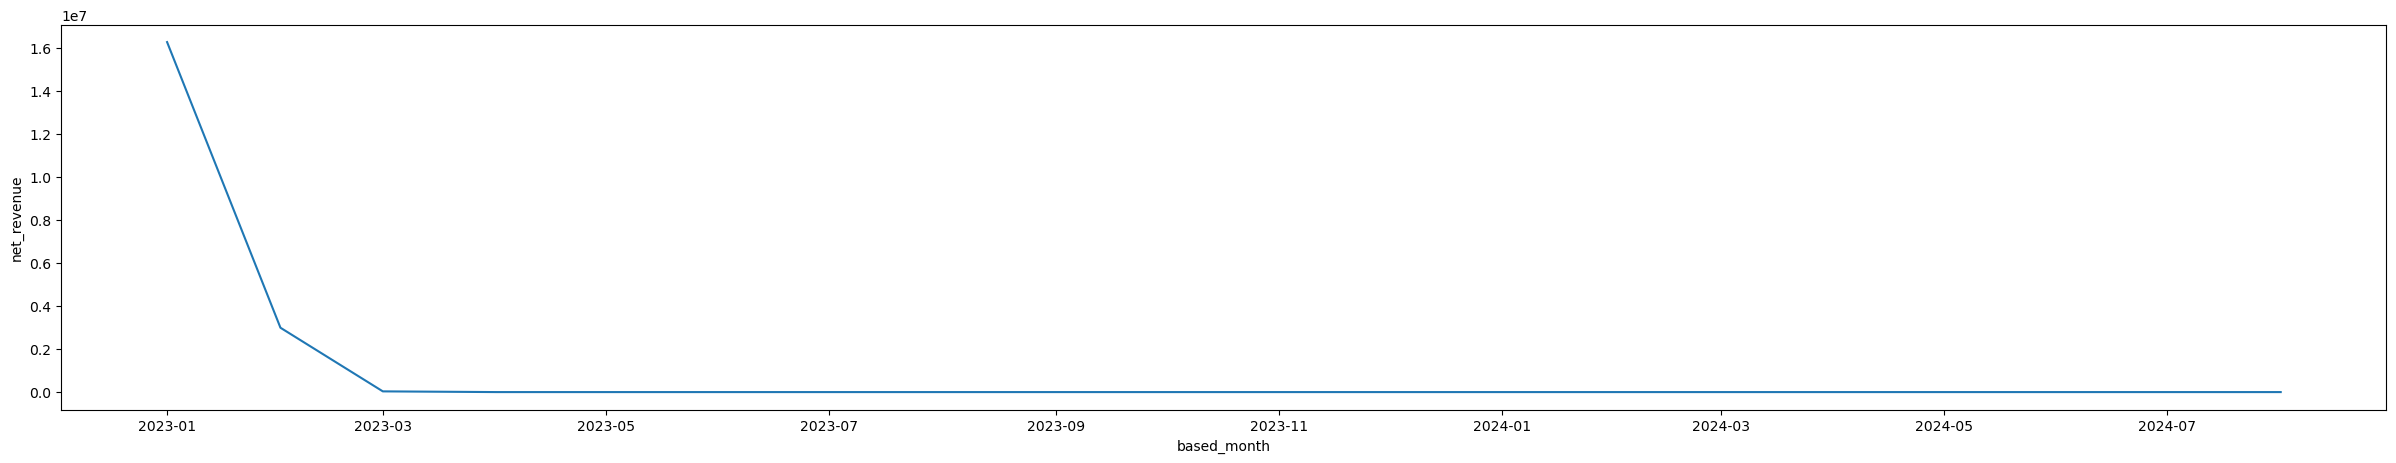

In [197]:
check = df[df['merchant_id'] == "abf7395ea48bd23545b65fc0cb5fea919c6a43f9135ef9bf930950e1edc6b323"]
print(check)
plt.figure(figsize=(30,5))
sns.lineplot(data = check, x = 'based_month', y = 'net_revenue')
plt.show()